In [1]:
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import seaborn as sns
from google.colab import files

In [2]:
# Choose random stocks based on group members'upcoming co-ops!

stocks = ['META', 'HD', 'UBS']
stocks_df = {
    'META' : pd.DataFrame(),
    'HD' : pd.DataFrame(),
    'UBS' : pd.DataFrame()
}

In [3]:
# Arbitrarily chosen start/end dates

start_date = '2010-01-01'
end_date = '2023-04-16'

for ticker in stocks:
    # Use yfinance library to get stock data
    stock = yf.download(ticker, start=start_date, end=end_date)
    # Add the stock data to the stock_data DataFrame
    stocks_df[ticker] = stock

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Train/test split for uncleaned data for plotting purposes in the future

true_data = {
    'HD': None,
    'META': None,
    'UBS': None
}

for key in true_data.keys():
    
    y = stocks_df[key]['Close']
    X = stocks_df[key].drop('Close', axis=1)
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.10, random_state=42, shuffle=False)
    
    true_data[key] = {
        "X_trn" : X_train,
        "X_val" : X_val,
        "X_tst" : X_test,
        "y_trn" : y_train,
        "y_val" : y_val,
        "y_tst" : y_test,
        "X": X,
        "y": y
    }

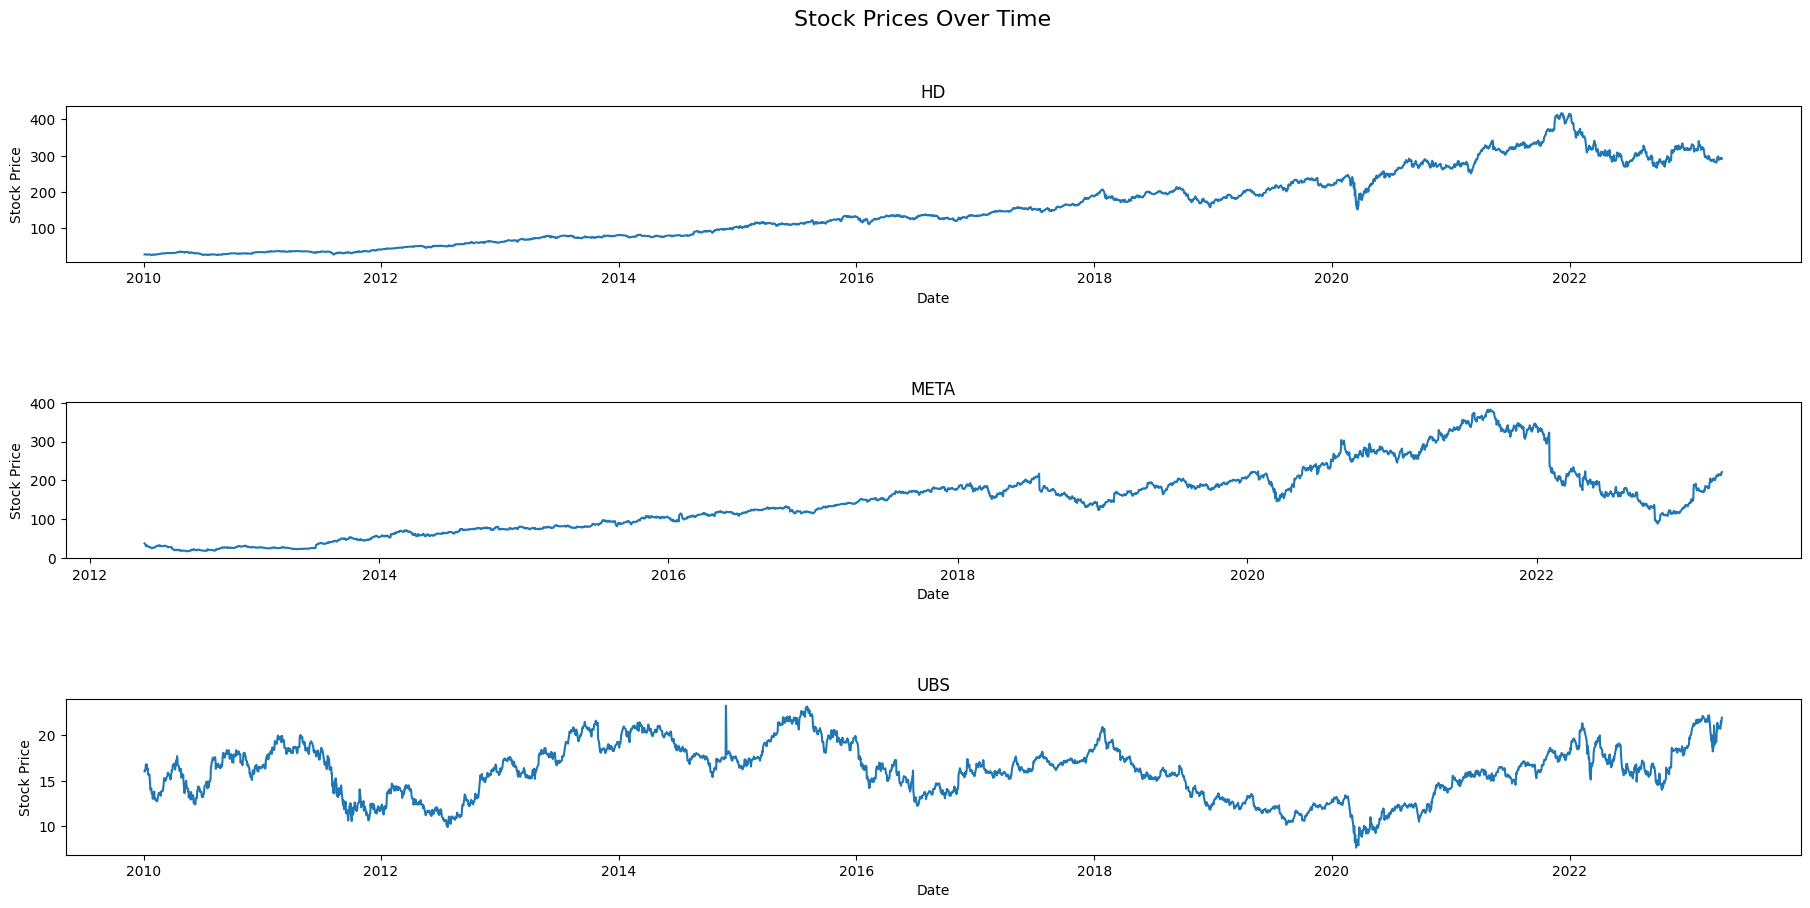

In [5]:
# Plot the stock prices over time

fig, ax = plt.subplots(3, figsize=(20, 10))
fig.tight_layout(pad=8.0)
fig.suptitle('Stock Prices Over Time', fontsize=16)

for idx, (name, df) in enumerate(true_data.items()):
  ax[idx].plot(df['y'])
  ax[idx].set_title(name)
  ax[idx].set_xlabel('Date')
  ax[idx].set_ylabel('Stock Price')

In [6]:
def create_lag(df, start=1, end=4):
    """
    Adds lag features for stock prices by adding previous days' close.

    Parameters:
        -- df: dataframe with each stock's features and values
        -- start: start day of lag (we use start days prior to today)
        -- end: end day of lag (we lag up to end days prior to today)
    """
    for i in range(start, end):
        df['Close_Lag' + str(i)] = df['Close'].shift(i)

In [7]:
def create_moving_avg(df, period):
    """
    Adds simple and exponential moving average for stock price.

    Parameters:
        -- df: dataframe with each stock's features and values
        -- period: how many days in the past we extend the moving average to
    """
    df['SMA' + str(period)] = df['Close'].rolling(window=period).mean()
    df['EMA' + str(period)] = df['Close'].ewm(span=period, adjust=True).mean()

In [8]:
def create_RSI(df, days=14):
    """
    Adds a relative strength index into each stock's dataframe.

    Parameters:
        -- df: dataframe with each stock's features and values
        -- days: how many days in the past we extend the RSI calculation to
    """
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=days).mean()
    avg_loss = loss.rolling(window=days).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

In [9]:
def select_features(df):
    """
    Drops unimportant features that we conclude to be Open, Adj Close,
    High, and Low.

    Parameters:
        -- df: dataframe with each stock's features and values
    """
    df.drop(['Open', 'Adj Close', 'High', 'Low'], axis=1, inplace=True)

In [10]:
def scale_values(name, df):
    """
    Scales every feature into values between 0 and 1 using 
    a MinMax scaler.

    Parameters:
        -- df: dataframe with each stock's features and values    """
    scaler = MinMaxScaler()
    result = np.where(df.columns == 'Close')[0]
    cols = np.delete(df.columns, result)
    df[cols] = scaler.fit_transform(df[cols])

In [11]:
def clean_df(name, df):
    """
    Cleans an entire dataframe of stock info 
    based on previous functions defined.

    Parameters:
        -- df: dataframe with each stock's features and values
        -- name: name of stock to store the scaler
    """
    create_lag(df, 1, 4)
    create_moving_avg(df, 5)
    create_RSI(df)
    df.dropna(inplace=True)
    select_features(df)
    scale_values(name, df)

In [12]:
# Clean all df

for name, df in stocks_df.items():
    clean_df(name, df)

stocks_df['HD'].head()

Close    Volume  Close_Lag1  Close_Lag2  Close_Lag3      SMA5  \
Date                                                                            
2010-01-22  27.719999  0.325091    0.003624    0.004086    0.004652  0.002334   
2010-01-25  27.620001  0.208450    0.001670    0.003624    0.004086  0.001843   
2010-01-26  27.730000  0.253817    0.001413    0.001670    0.003624  0.001247   
2010-01-27  27.840000  0.244358    0.001696    0.001413    0.001670  0.000823   
2010-01-28  27.340000  0.382052    0.001979    0.001696    0.001413  0.000233   

                EMA5    RSI_14  
Date                            
2010-01-22  0.001658  0.330660  
2010-01-25  0.001089  0.320178  
2010-01-26  0.000805  0.302105  
2010-01-27  0.000711  0.332435  
2010-01-28  0.000216  0.222906

In [13]:
# Define Train/Test Split and store
# 10% Test, 9% Validation, 81% Train

data = {
    'HD': None,
    'META': None,
    'UBS': None
}

for key in data.keys():
    
    y = stocks_df[key]['Close']
    X = stocks_df[key].drop('Close', axis=1)
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.10, random_state=42, shuffle=False)
    
    data[key] = {
        "X_trn" : X_train,
        "X_val" : X_val,
        "X_tst" : X_test,
        "y_trn" : y_train,
        "y_val" : y_val,
        "y_tst" : y_test,
        "X": X,
        "y": y
    }

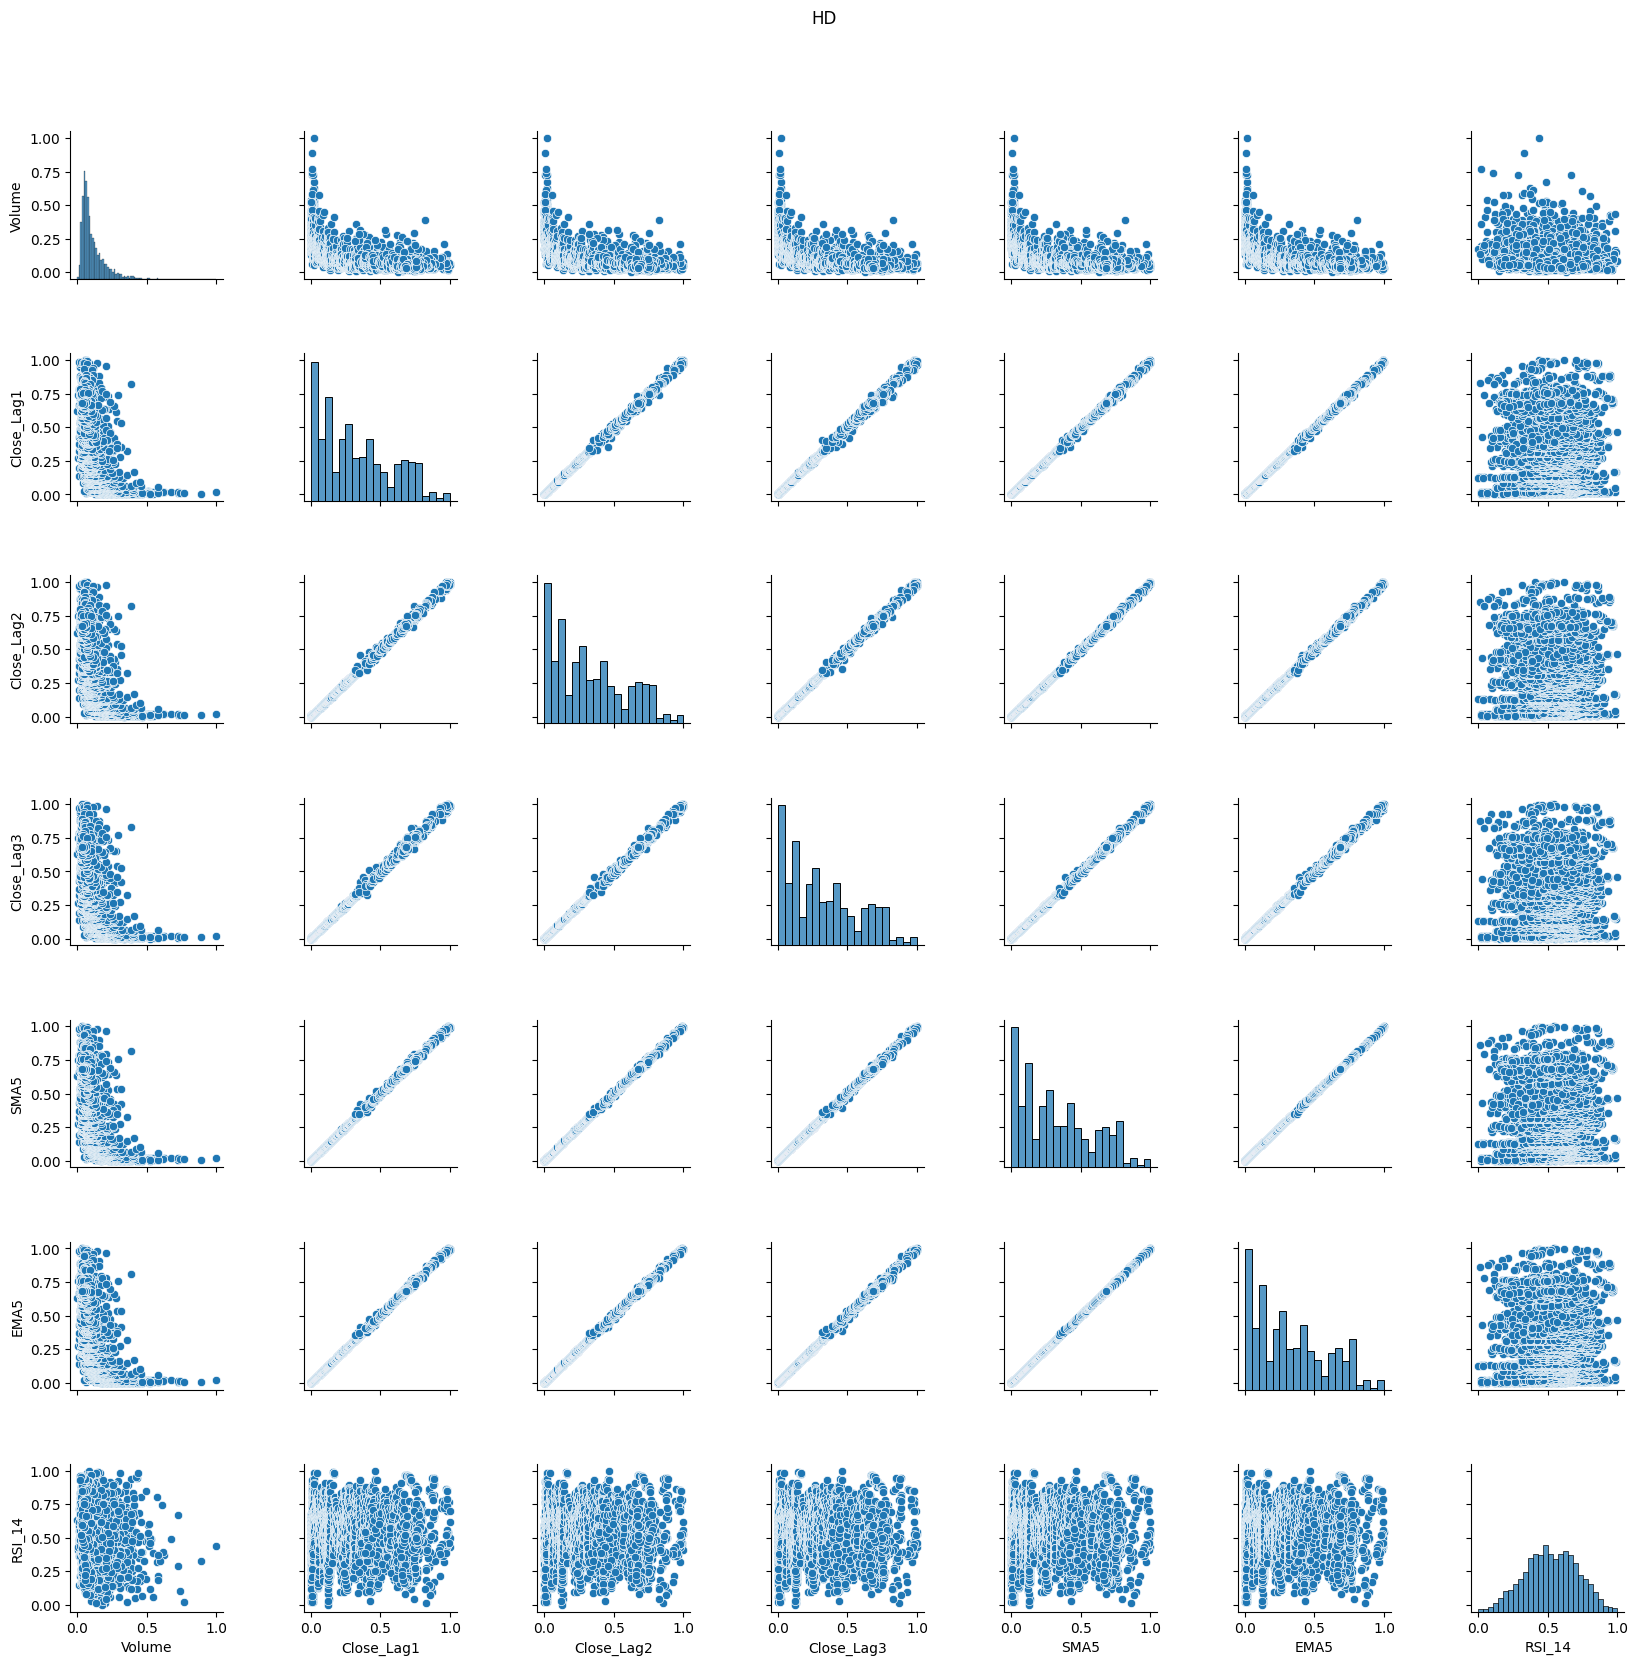

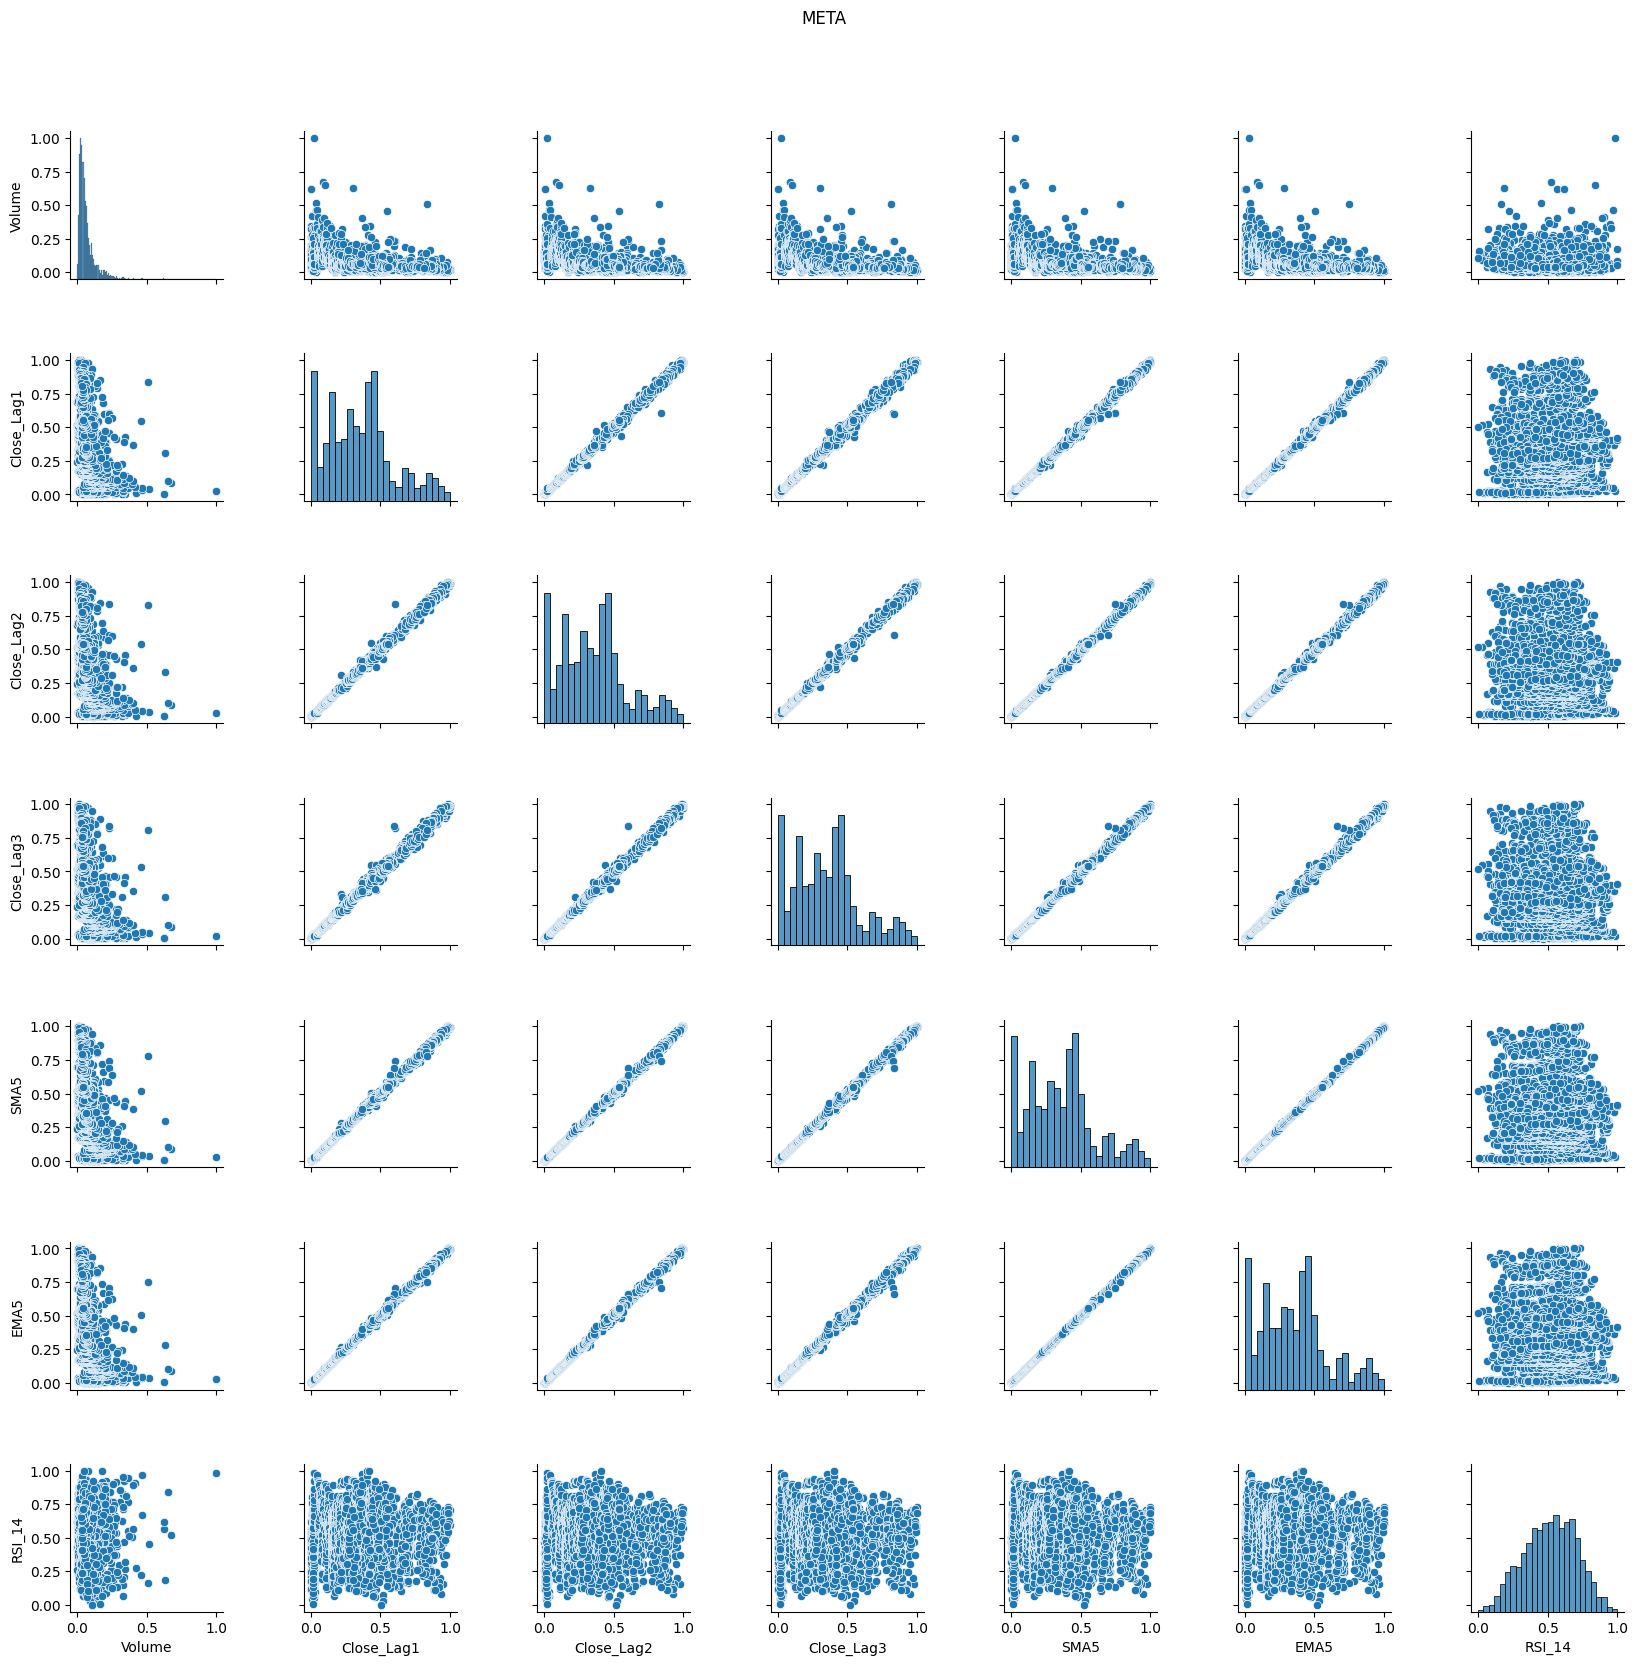

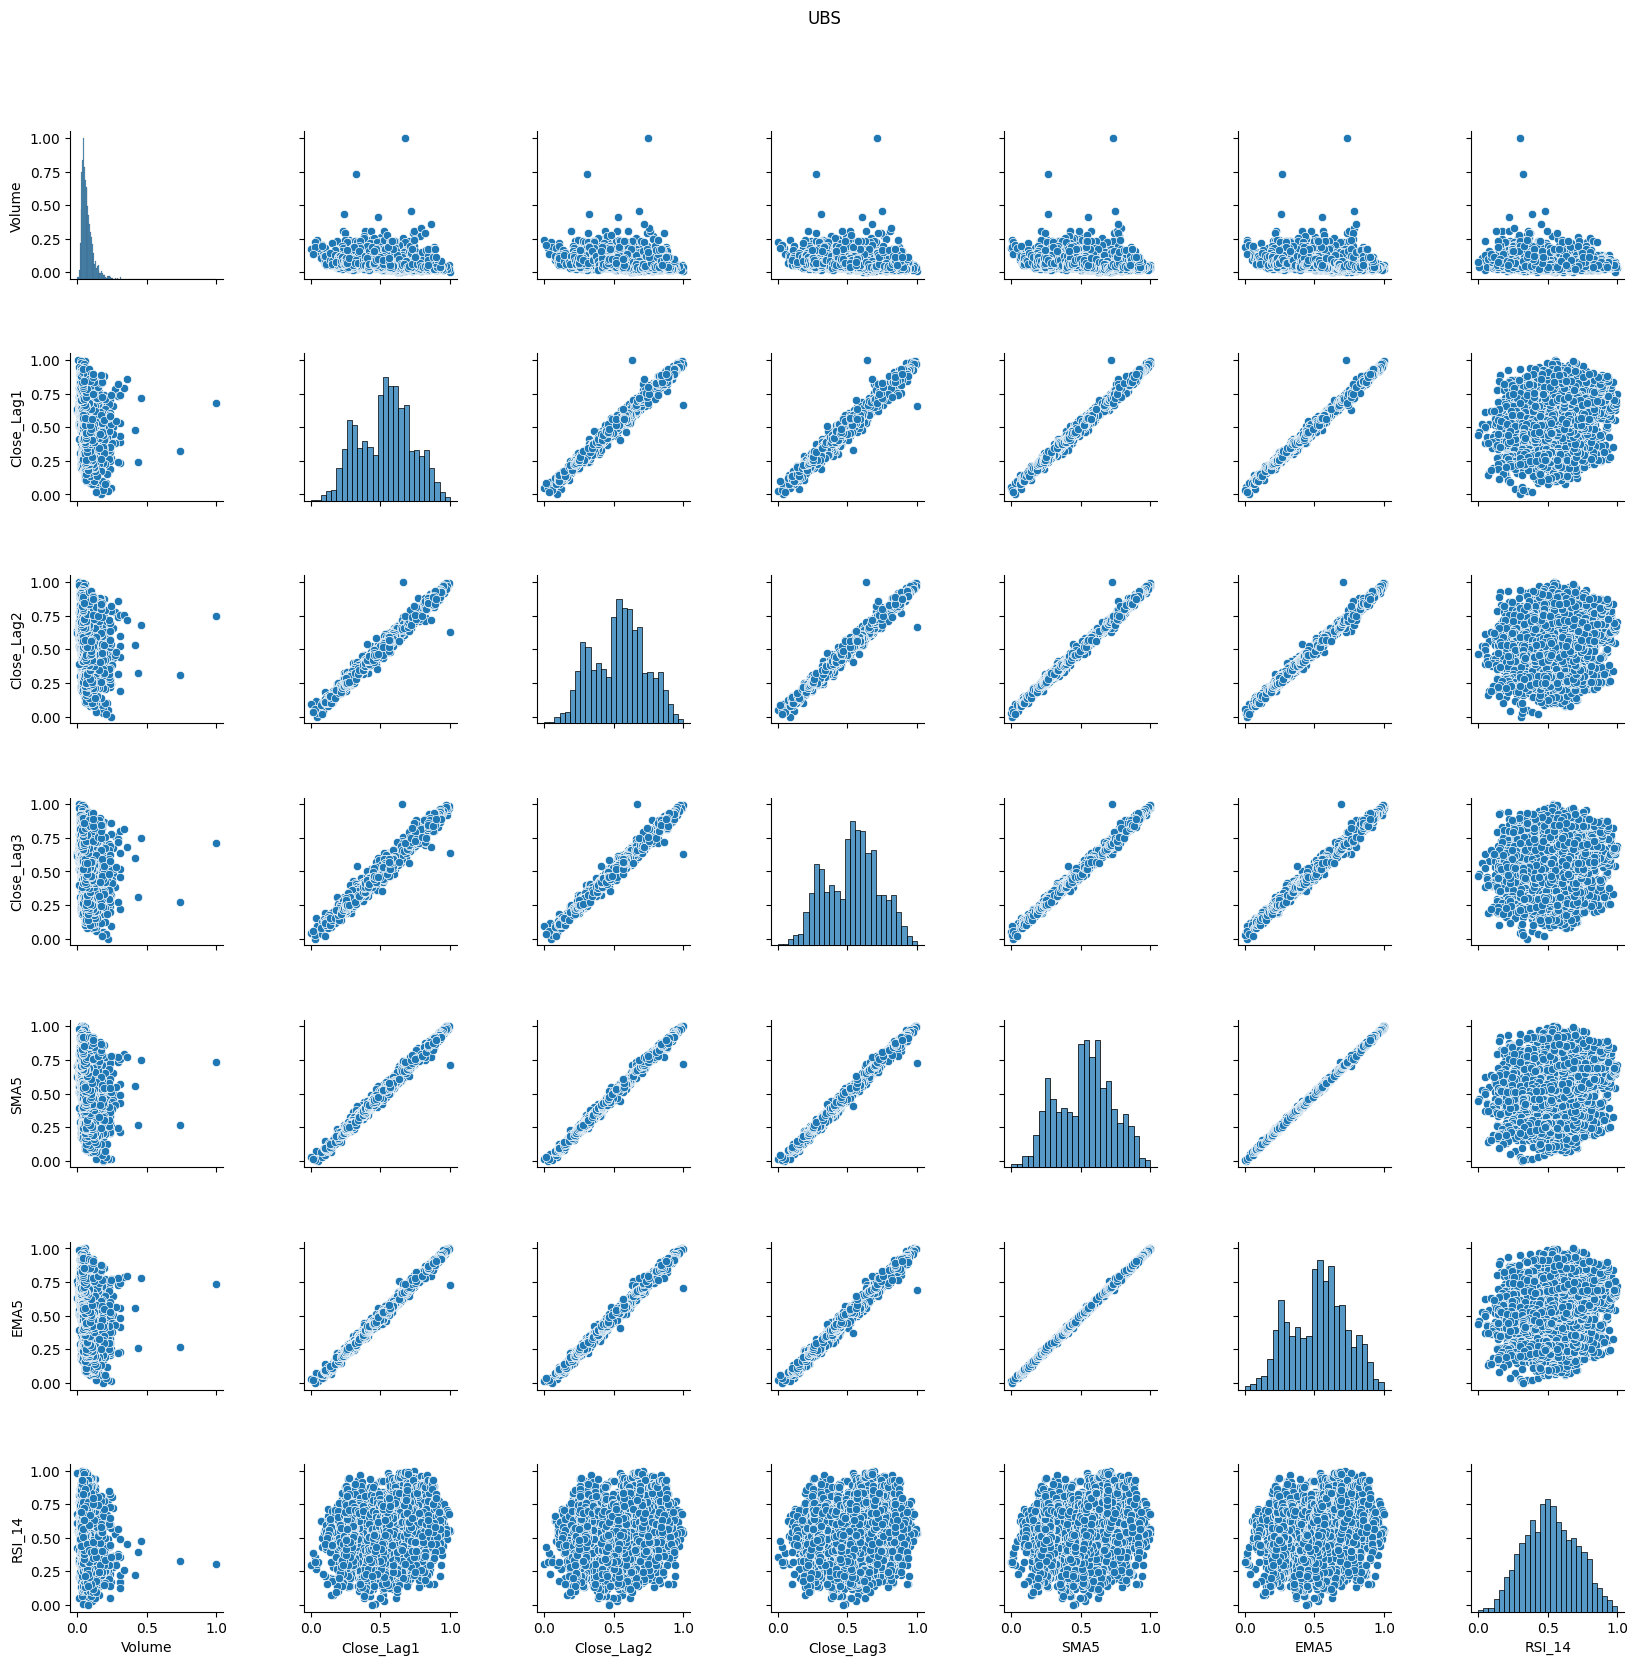

In [14]:
# Correlation between features for each stock

for idx, (name, df) in enumerate(data.items()):
  cols = df['X'].columns
  corr = sns.pairplot(df['X'][cols])
  corr.fig.suptitle(name)
  corr.fig.tight_layout(pad=5.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

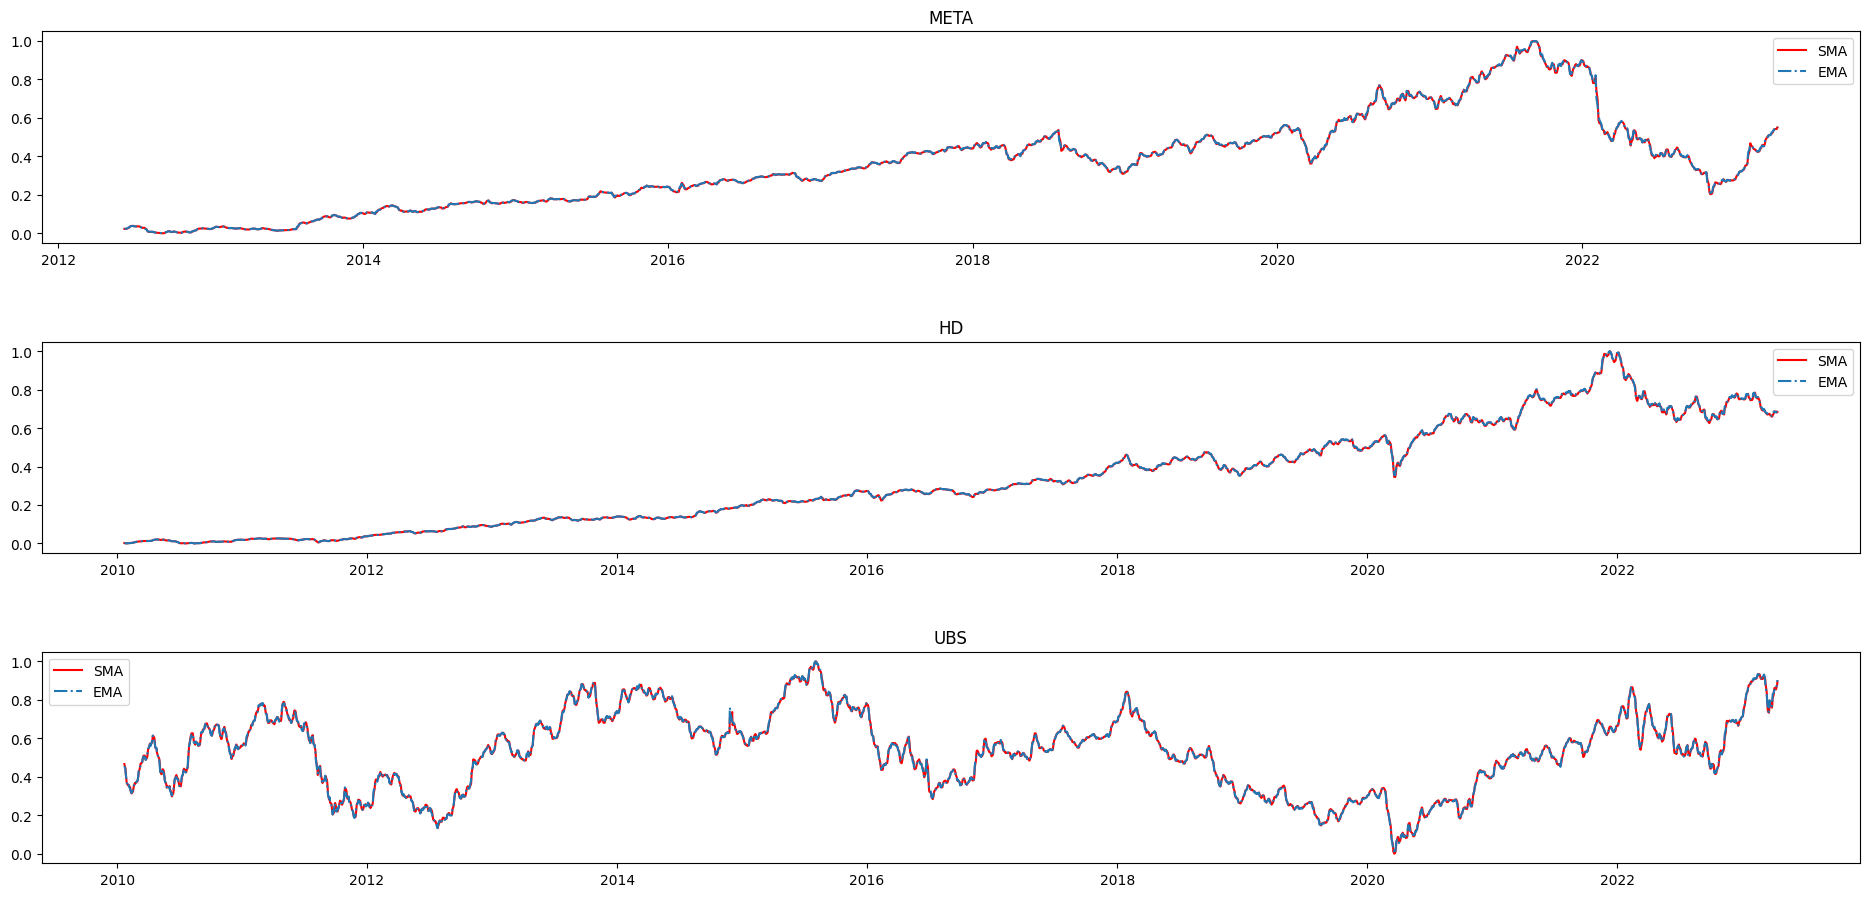

In [15]:
# Plot Simple and Exponential Moving Average

fig, ax = plt.subplots(3, figsize=(20, 10))
fig.tight_layout(pad=5.0)

for idx, (name, df) in enumerate(stocks_df.items()):
  ax[idx].plot(df.SMA5, color='red', label='SMA')
  ax[idx].plot(df.EMA5, linestyle='dashdot', label='EMA')
  ax[idx].legend()
  ax[idx].set_title(name)

fig.savefig("simple_exponential_MA.png")
files.download("simple_exponential_MA.png") 

In [16]:
# Remove EMA because it is redundant

for name, df in stocks_df.items():
    df.drop(['EMA5'], axis=1, inplace=True)

stocks_df['HD'].head()

Close    Volume  Close_Lag1  Close_Lag2  Close_Lag3      SMA5  \
Date                                                                            
2010-01-22  27.719999  0.325091    0.003624    0.004086    0.004652  0.002334   
2010-01-25  27.620001  0.208450    0.001670    0.003624    0.004086  0.001843   
2010-01-26  27.730000  0.253817    0.001413    0.001670    0.003624  0.001247   
2010-01-27  27.840000  0.244358    0.001696    0.001413    0.001670  0.000823   
2010-01-28  27.340000  0.382052    0.001979    0.001696    0.001413  0.000233   

              RSI_14  
Date                  
2010-01-22  0.330660  
2010-01-25  0.320178  
2010-01-26  0.302105  
2010-01-27  0.332435  
2010-01-28  0.222906

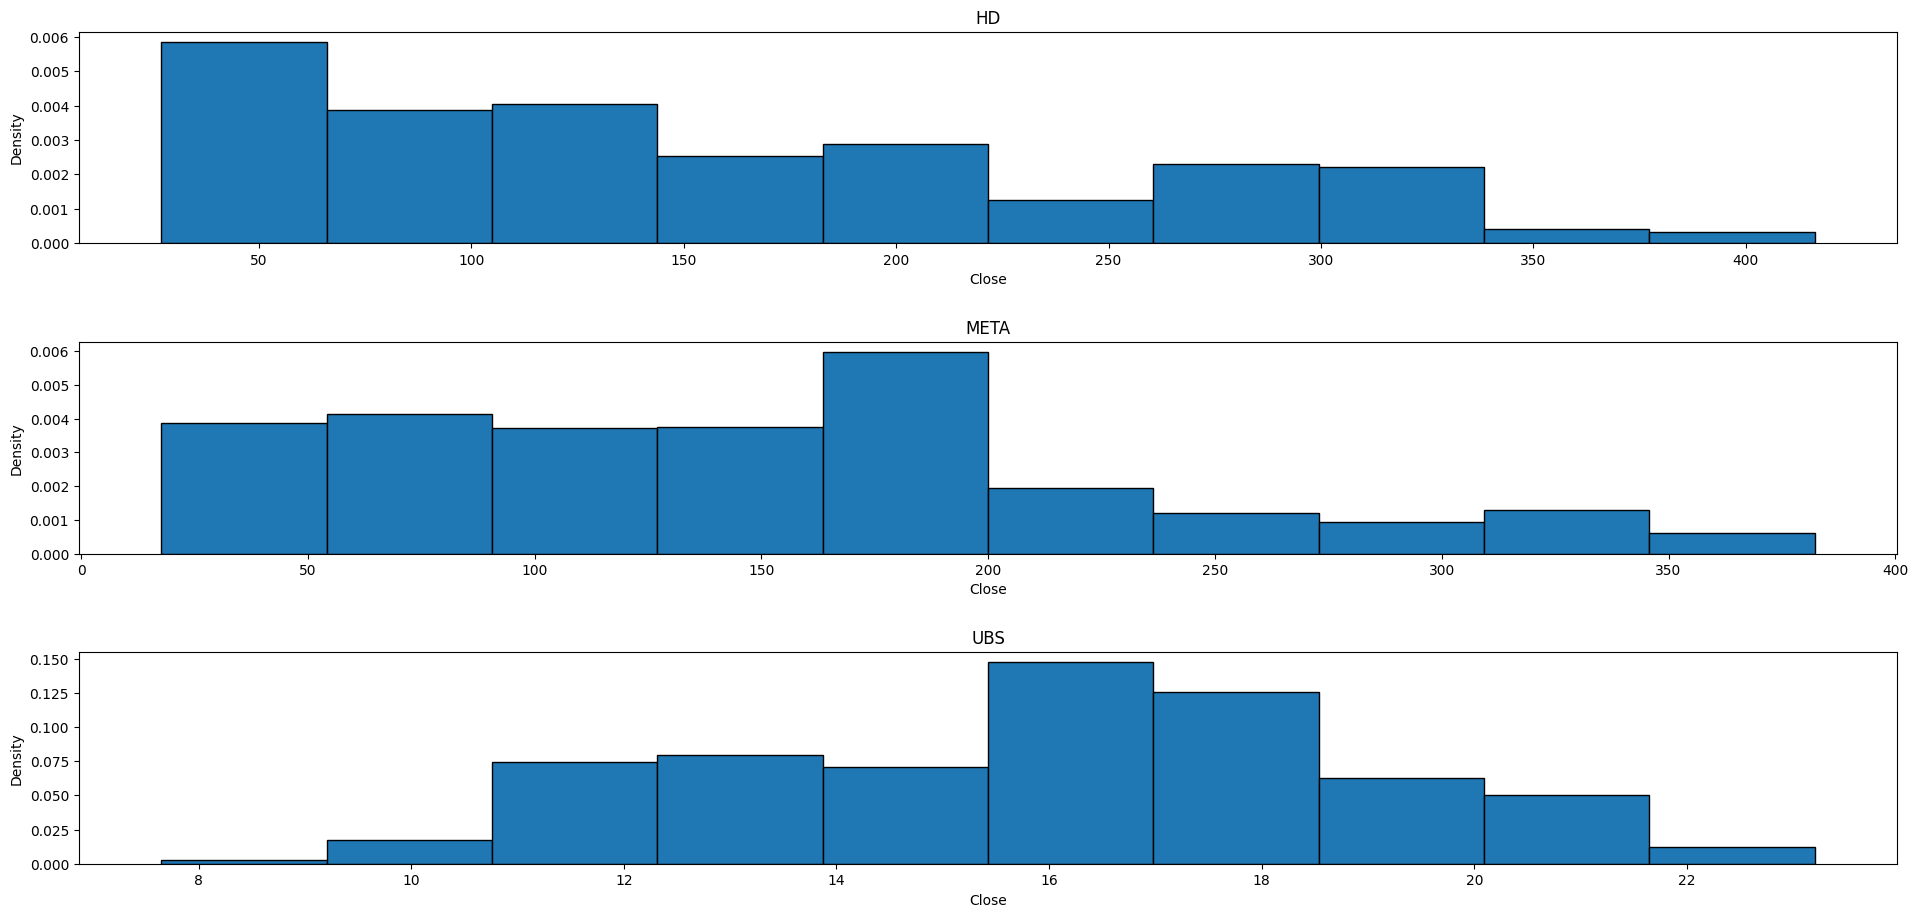

In [17]:
# Hisogram for close for each stock

fig, ax = plt.subplots(3, figsize=(20, 10))
fig.tight_layout(pad=5.0)

for idx, (name, df) in enumerate(data.items()):
  ax[idx].hist(df['y'], edgecolor='black', density=True)
  ax[idx].set_xlabel('Close')
  ax[idx].set_ylabel('Density')
  ax[idx].set_title(name)

In [18]:
# Basic statistics for scaled close price

described = pd.DataFrame(columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 
                         index=['HD', 'META', 'UBS'])

for idx, (name, df) in enumerate(data.items()):
  described.iloc[idx] = df['y'].describe()

described.head()

count        mean        std    min        25%         50%         75%  \
HD    3330.0  154.853937  98.832419  27.07  73.915001  133.934998  224.649998   
META  2731.0  149.281164  85.917122  17.73  78.994999  146.089996  191.904999   
UBS   3330.0   15.997572   2.980131   7.65      13.66      16.205   18.049999   

             max  
HD    416.179993  
META  382.179993  
UBS    23.200001

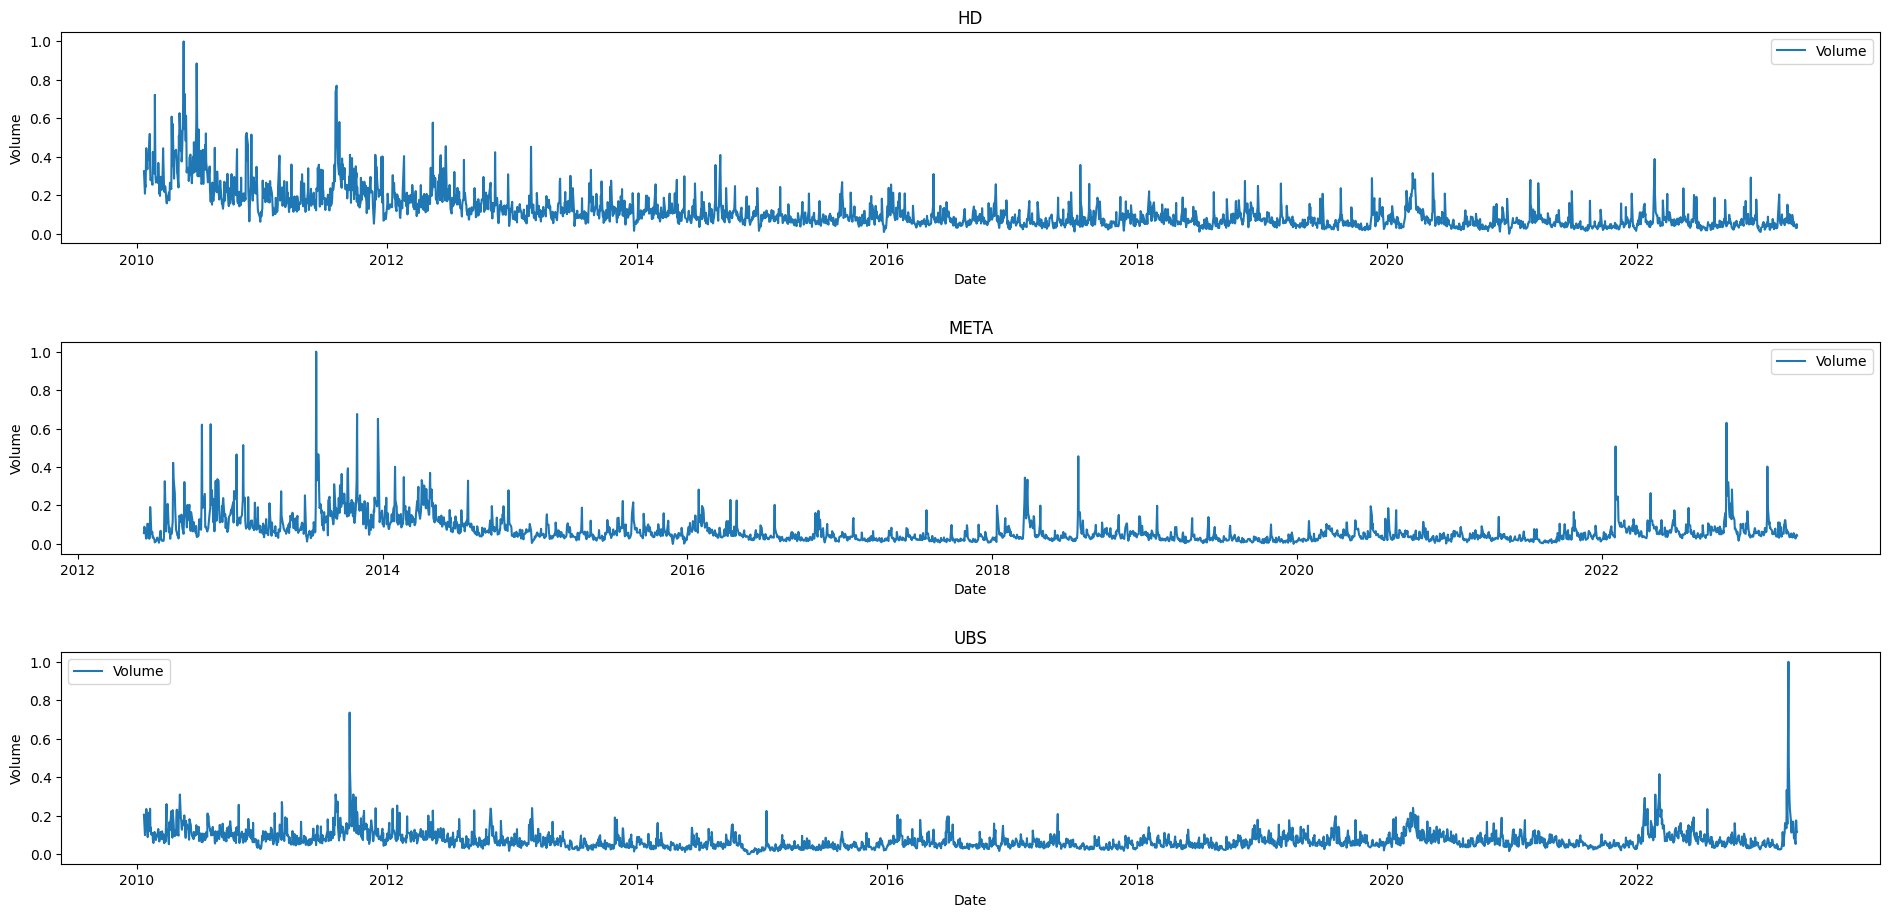

In [19]:
# Plot volume over time

fig, ax = plt.subplots(3, figsize=(20, 10))
fig.tight_layout(pad=5.0)

for idx, (name, df) in enumerate(data.items()):
  ax[idx].plot(df['X']['Volume'], label='Volume')
  ax[idx].set_xlabel('Date')
  ax[idx].set_ylabel('Volume')
  ax[idx].set_title(name)
  ax[idx].legend()

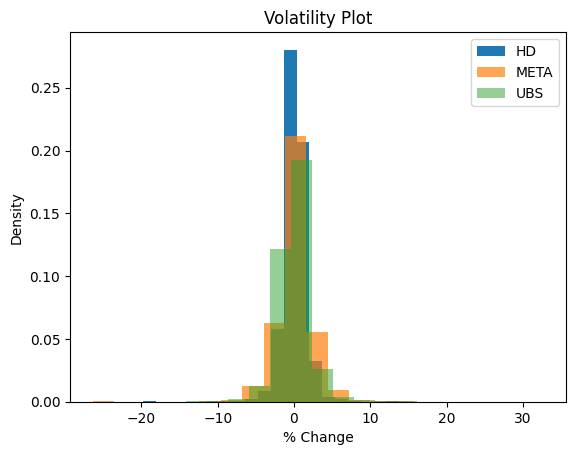

In [20]:
# Plot volatility

alphas = [1, 0.7, 0.5]

for idx, (name, df) in enumerate(true_data.items()):
  pct_changes = df['y'].pct_change()[1:] * 100
  plt.hist(pct_changes, alpha=alphas[idx], bins=20, label=name, density=True)
  plt.title('Volatility Plot')
  plt.xlabel('% Change')
  plt.ylabel('Density')
  plt.legend()

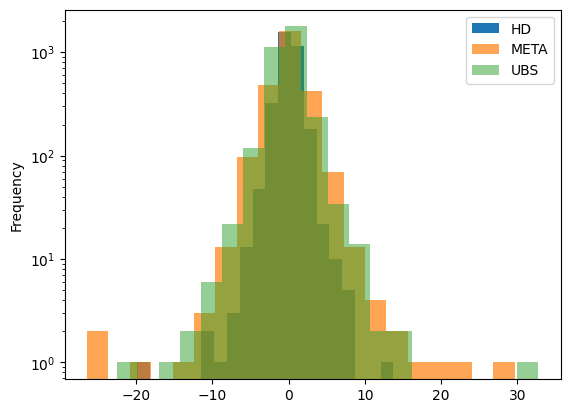

In [21]:
# Plot volatility

alphas = [1, 0.7, 0.5]

for idx, (name, df) in enumerate(true_data.items()):
  pct_changes = df['y'].pct_change()[1:] * 100
  pct_changes.plot(kind='hist', logy=True, label=name, alpha=alphas[idx], bins=20)
  plt.legend()

### Train/Test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

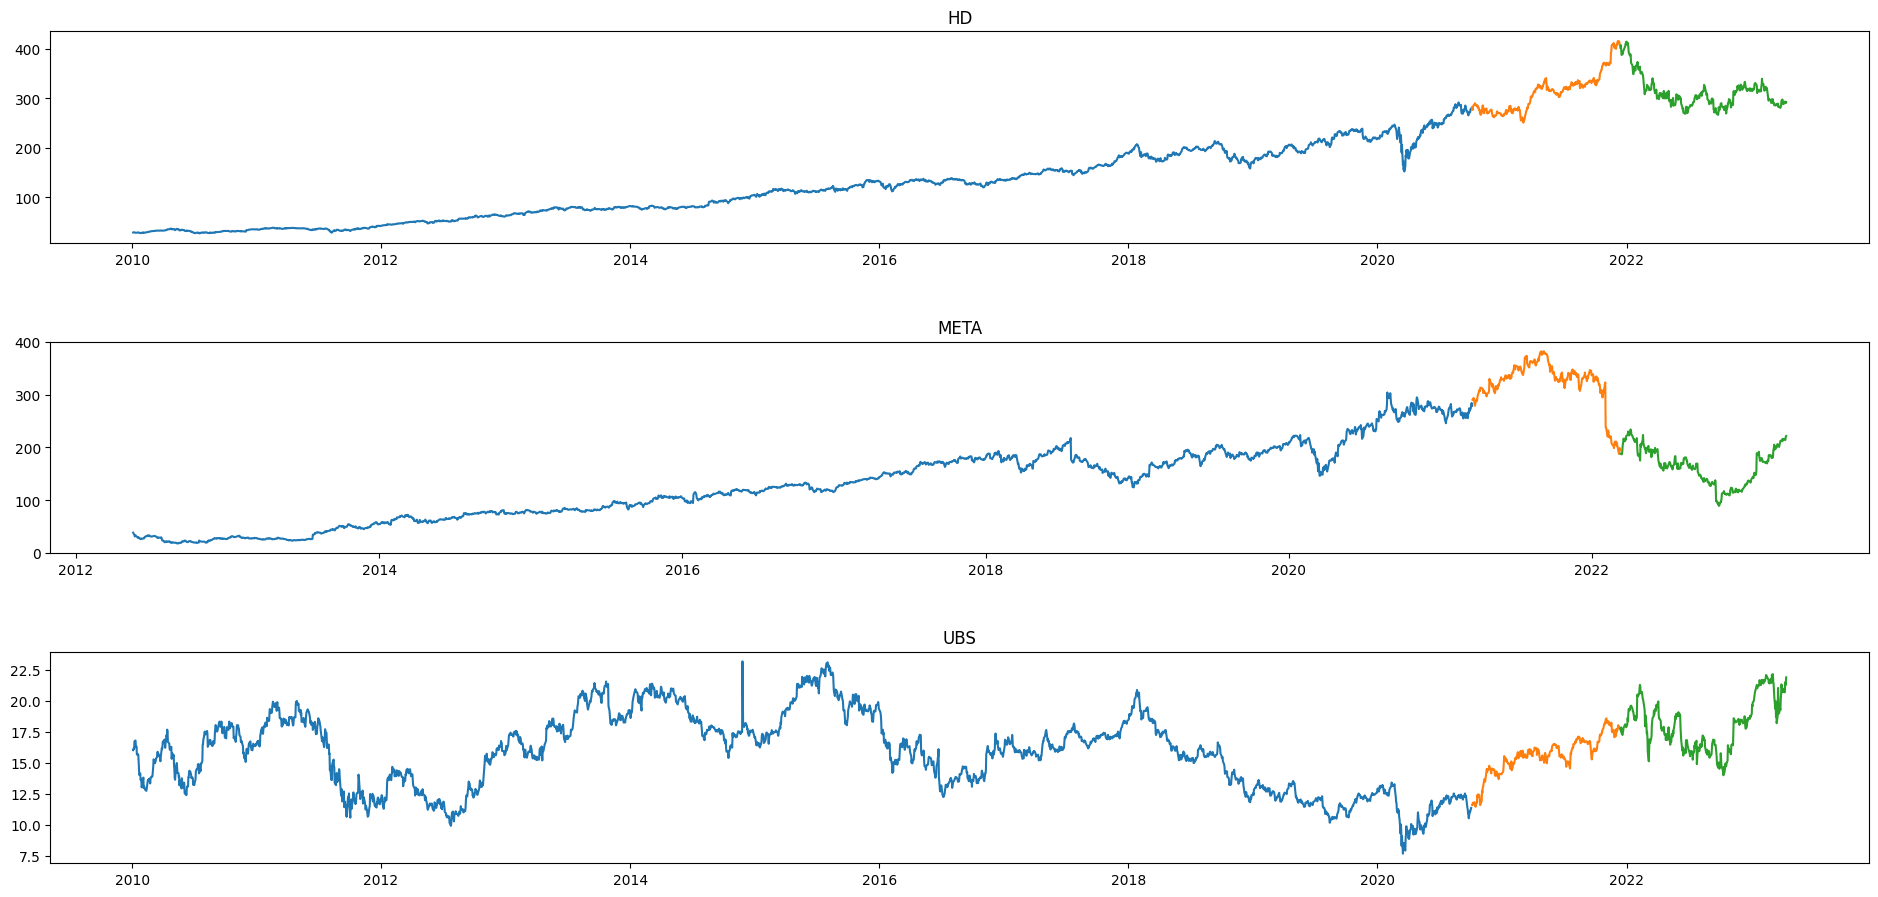

In [22]:
fig, ax = plt.subplots(3, figsize=(20, 10))
fig.tight_layout(pad=5.0)

for idx, (name, vals) in enumerate(true_data.items()):
  y_trn = vals['y_trn']
  y_val = vals['y_val']
  y_tst = vals['y_tst']

  ax[idx].plot(y_trn, label='train')
  ax[idx].plot(y_val, label='validate')
  ax[idx].plot(y_tst, label='test')
  ax[idx].plot()
  ax[idx].set_title(name)


fig.savefig("traintest.png")
files.download("traintest.png") 

In [23]:
def create_sequences(X, y, time_steps=1):
    """
    Creates input-output pairs using sliding window approach.

    Parameters:
        -- X: numpy array, input data
        -- y: numpy array, target data
        -- time_steps: int, size of the sliding window

    Returns:
        -- X_seq: numpy array, input sequences
        -- y_seq: numpy array, output sequences
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    a, b = np.array(X_seq), np.array(y_seq)
    return np.array(X_seq), np.array(y_seq)

In [24]:
time_steps = 10

for key, value in data.items():
    
    # Create sequences for training data
    X_train_seq, y_train_seq = create_sequences(value['X_trn'], value['y_trn'], time_steps)
    # Create sequences for validation data
    X_val_seq, y_val_seq = create_sequences(value['X_val'], value['y_val'], time_steps)
    # Create sequences for test data
    X_test_seq, y_test_seq = create_sequences(value['X_tst'], value['y_tst'], time_steps)
    
    value['X_trn'] = X_train_seq
    value['X_val'] = X_val_seq
    value['X_tst'] = X_test_seq
    value['y_trn'] = y_train_seq
    value['y_val'] = y_val_seq
    value['y_tst'] = y_test_seq

In [25]:
for key, value in data.items():
    
    num_features = 7
    
    # Convert input sequences to numpy arrays
    value['X_trn'] = np.array(value['X_trn'])
    value['X_val'] = np.array(value['X_val'])
    value['X_tst'] = np.array(value['X_tst'])

    # Convert output sequences to numpy arrays
    value['y_trn'] = np.array(value['y_trn'])
    value['y_val'] = np.array(value['y_val'])
    value['y_tst'] = np.array(value['y_tst'])

Epoch 1/100
84/84 [==============================] - 13s 31ms/step - loss: 14314.2090 - val_loss: 74089.8203
Epoch 2/100
84/84 [==============================] - 2s 18ms/step - loss: 6978.5679 - val_loss: 49279.2500
Epoch 3/100
84/84 [==============================] - 2s 27ms/step - loss: 4695.0508 - val_loss: 40908.9062
Epoch 4/100
84/84 [==============================] - 3s 30ms/step - loss: 4578.9761 - val_loss: 40392.3906
Epoch 5/100
84/84 [==============================] - 2s 26ms/step - loss: 4400.8794 - val_loss: 38295.5156
Epoch 6/100
84/84 [==============================] - 2s 27ms/step - loss: 1315.7041 - val_loss: 20328.3027
Epoch 7/100
84/84 [==============================] - 2s 19ms/step - loss: 425.5145 - val_loss: 13691.7988
Epoch 8/100
84/84 [==============================] - 2s 19ms/step - loss: 253.9110 - val_loss: 10736.6865
Epoch 9/100
84/84 [==============================] - 2s 20ms/step - loss: 184.9906 - val_loss: 8952.3701
Epoch 10/100
84/84 [===================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

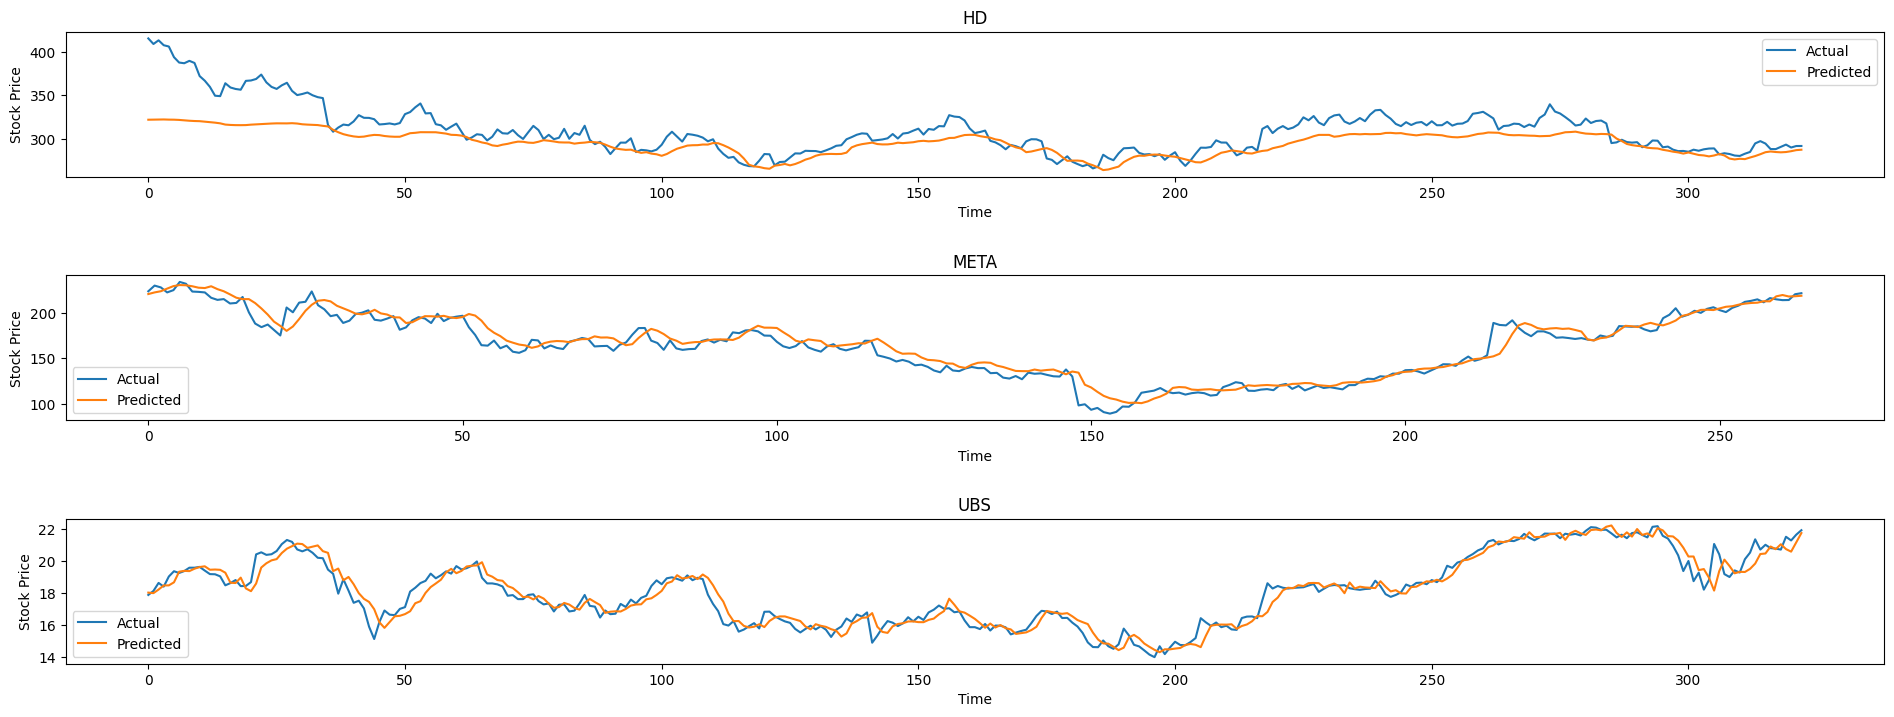

In [27]:
fig, ax = plt.subplots(3, figsize=(20, 8))
fig.tight_layout(pad=5.0)

for idx, (key, val) in enumerate(data.items()): 
  X_train = val['X_trn']
  X_val = val['X_val']
  X_test = val['X_tst']
  y_train = val['y_trn']
  y_val = val['y_val']
  y_test = val['y_tst']

  # Define LSTM model
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=True)

  # Evaluate the model
  train_loss = model.evaluate(X_train, y_train, verbose=0)
  val_loss = model.evaluate(X_val, y_val, verbose=0)
  test_loss = model.evaluate(X_test, y_test, verbose=0)
  print('Train Loss:', train_loss)
  print('Validation Loss:', val_loss)
  print('Test Loss:', test_loss)
  
  # Predict stock prices using the trained model
  y_pred = model.predict(X_test)

  # Plot actual stock prices
  ax[idx].plot(y_test, label='Actual')
  # Plot predicted stock prices
  ax[idx].plot(y_pred, label='Predicted')

  ax[idx].set_xlabel('Time')
  ax[idx].set_ylabel('Stock Price')
  ax[idx].set_title(key)
  ax[idx].legend()

fig.savefig("lstm.png")
files.download("lstm.png") 

### Let's compare with a linear regression

In [28]:
# Reset all the dataframes

stocks_regression = ['HD', 'META', 'UBS']
stocks_df_regression = {
    'HD' : pd.DataFrame(),
    'META' : pd.DataFrame(),
    'UBS' : pd.DataFrame()
}

start_date = '2010-01-01'
end_date = '2023-04-16'

for ticker in stocks:
    # Use yfinance library to get stock data
    stock = yf.download(ticker, start=start_date, end=end_date)
    # Add the stock data to the stock_data DataFrame
    stocks_df_regression[ticker] = stock

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
# Clean the df again

for name, df in stocks_df_regression.items():
    clean_df(name, df)  

stocks_df_regression['HD'].head()

Close    Volume  Close_Lag1  Close_Lag2  Close_Lag3      SMA5  \
Date                                                                            
2010-01-22  27.719999  0.325091    0.003624    0.004086    0.004652  0.002334   
2010-01-25  27.620001  0.208450    0.001670    0.003624    0.004086  0.001843   
2010-01-26  27.730000  0.253817    0.001413    0.001670    0.003624  0.001247   
2010-01-27  27.840000  0.244358    0.001696    0.001413    0.001670  0.000823   
2010-01-28  27.340000  0.382052    0.001979    0.001696    0.001413  0.000233   

                EMA5    RSI_14  
Date                            
2010-01-22  0.001658  0.330660  
2010-01-25  0.001089  0.320178  
2010-01-26  0.000805  0.302105  
2010-01-27  0.000711  0.332435  
2010-01-28  0.000216  0.222906

In [30]:
# Define train/test split

data_regression = {
    'HD': None,
    'META': None,
    'UBS': None
}

for key in data_regression.keys():
    
    y = stocks_df_regression[key]['Close']
    X = stocks_df_regression[key].drop('Close', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=False)
    
    data_regression[key] = {
        "X_trn" : X_train,
        "X_tst" : X_test,
        "y_trn" : y_train,
        "y_tst" : y_test
    }

In [31]:
# Apply lasso regresison funding the best value of alpha

alphas = np.arange(0, 0.1, 0.005)
best_alpha = [None, None, None]
best_pred = [None, None, None]
train_error = [float('inf'), float('inf'), float('inf')]
best_error = [float('inf'), float('inf'), float('inf')]

for idx, (key, value) in enumerate(data_regression.items()):
  for alpha in alphas:
    reg = linear_model.Lasso(alpha=alpha)
    reg.fit(value['X_trn'], value['y_trn'])
    pred = reg.predict(value['X_tst'])
    error = mean_squared_error(value['y_tst'], pred)
    if error < best_error[idx]:
      best_error[idx] = error
      best_pred[idx] = pred
      train_error[idx] = mean_squared_error(value['y_trn'].values, reg.predict(value['X_trn']))
      best_alpha[idx] = alpha

print(train_error)
print(best_error)
print(best_alpha)

<ipython-input-31-7dc397782b70>:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg.fit(value['X_trn'], value['y_trn'])
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.300e+03, tolerance: 2.304e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-pa

[4.871603237449425, 9.980278542811714, 0.02743831870194963]
[29.57394447419313, 24.56509377009946, 0.05809313553350454]
[0.0, 0.0, 0.0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

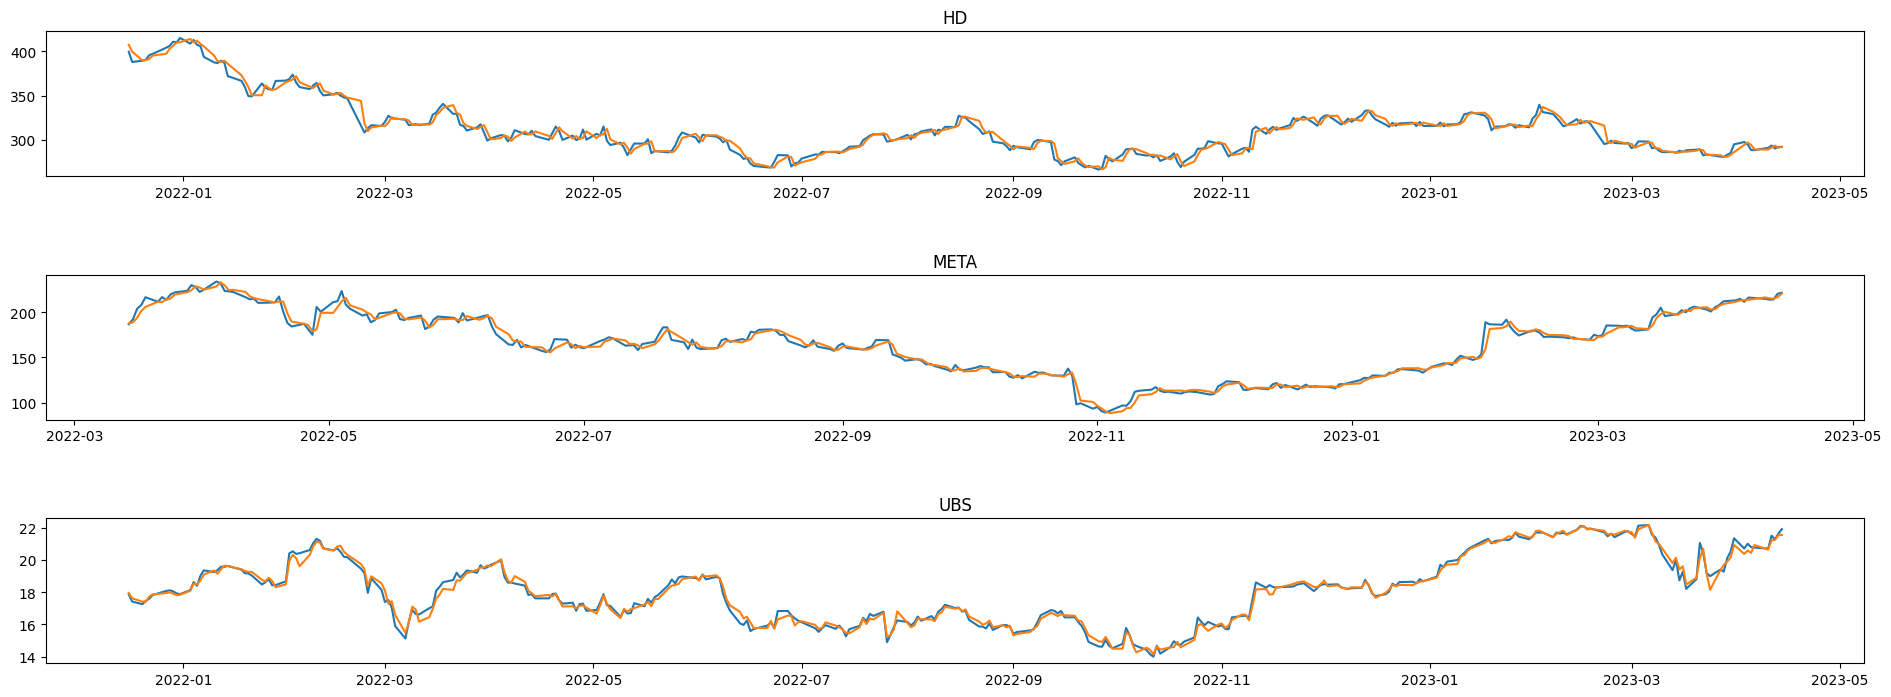

In [32]:
fig, ax = plt.subplots(3, figsize=(20, 8))
fig.tight_layout(pad=5.0)

for i, (k, v) in enumerate(data_regression.items()):
  ax[i].plot(v['y_tst'])
  ax[i].plot(pd.Series(best_pred[i], index=v['y_tst'].index))
  ax[i].set_title(k)

fig.savefig("lasso1.png")
files.download("lasso1.png") 

### Interestingly, it performs just as well! Now let's try removing the paramters that we specifically added and see if it works as well.

In [33]:
stocks_regression2 = ['HD', 'META', 'UBS']
stocks_df_regression2 = {
    'HD' : pd.DataFrame(),
    'META' : pd.DataFrame(),
    'UBS' : pd.DataFrame()
}

start_date = '2010-01-01'
end_date = '2023-04-16'

for ticker in stocks:
    # Use yfinance library to get stock data
    stock = yf.download(ticker, start=start_date, end=end_date)
    # Add the stock data to the stock_data DataFrame
    stocks_df_regression2[ticker] = stock

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [34]:
for name, df in stocks_df_regression2.items():
    create_lag(df, 5, 10)
    df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True) 
    scale_values(name, df)
    df.dropna(inplace=True)

stocks_df_regression2['HD'].head()

Close  Close_Lag5  Close_Lag6  Close_Lag7  Close_Lag8  \
Date                                                                    
2010-01-15  28.570000    0.004909    0.005268    0.004395    0.004652   
2010-01-19  28.879999    0.002801    0.004909    0.005268    0.004395   
2010-01-20  28.660000    0.002339    0.002801    0.004909    0.005268   
2010-01-21  28.480000    0.002724    0.002339    0.002801    0.004909   
2010-01-22  27.719999    0.003161    0.002724    0.002339    0.002801   

            Close_Lag9  
Date                    
2010-01-15    0.004112  
2010-01-19    0.004652  
2010-01-20    0.004395  
2010-01-21    0.005268  
2010-01-22    0.004909

In [35]:
data_regression2 = {
    'HD': None,
    'META': None,
    'UBS': None
}

for key in data_regression2.keys():
    
    y = stocks_df_regression2[key]['Close']
    X = stocks_df_regression2[key].drop(['Close'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=False)
    
    data_regression2[key] = {
        "X_trn" : X_train,
        "X_tst" : X_test,
        "y_trn" : y_train,
        "y_tst" : y_test
    }

In [36]:
pred = [None, None, None]
train_error =  [float('inf'), float('inf'), float('inf')]
error = [float('inf'), float('inf'), float('inf')]
for idx, (key, value) in enumerate(data_regression2.items()):
  reg = LinearRegression().fit(value['X_trn'], value['y_trn'])
  prediction = reg.predict(value['X_tst'])
  pred[idx] = prediction
  train_error[idx] = mean_squared_error(value['y_trn'].values, reg.predict(value['X_trn']))
  error[idx] = mean_squared_error(value['y_tst'].values, prediction)
  # print(reg.coef_, reg.intercept_)
print(train_error)
print(error)

[28.531959090392693, 66.93304906835733, 0.4249635184351949]
[178.0757128720806, 177.71406159723853, 0.9408962796004766]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

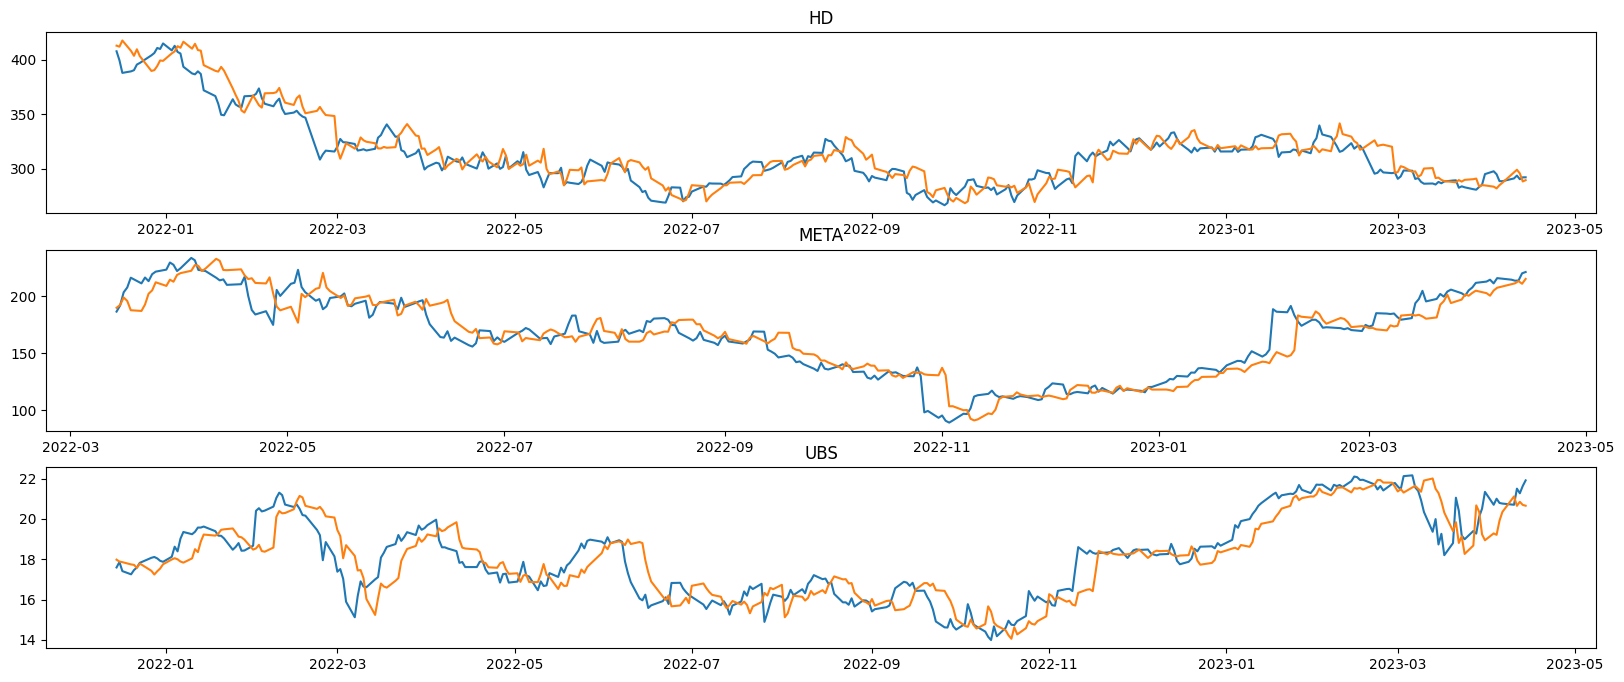

In [37]:
fig, ax = plt.subplots(3, figsize=(20, 8))
for i, (k, v) in enumerate(data_regression2.items()):
  ax[i].plot(v['y_tst'])
  ax[i].plot(pd.Series(pred[i], index=v['y_tst'].index))
  ax[i].set_title(k)


fig.savefig("lasso1.png")
files.download("lasso1.png") 

### Both methods worked quite well.